In [95]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [96]:
def extract_leaf_regions_with_bboxes_and_bases(
    image_path,
    center_landmarks,
    base_landmarks,
    dilation_iter=5,
    min_area=500
):
    import cv2
    import numpy as np
    from skimage.measure import label, regionprops
    from skimage.morphology import skeletonize
    from scipy.spatial import ConvexHull, distance

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.bilateralFilter(img, 1, 100, 100)

    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(thresh)

    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(inverted, kernel, iterations=dilation_iter)

    labeled = label(dilated)
    props = regionprops(labeled)

    landmark_assignments = {}
    for i, (x, y) in enumerate(center_landmarks):
        min_dist = float('inf')
        assigned_label = None
        for region in props:
            if region.area >= min_area:
                cy, cx = region.centroid
                dist = np.hypot(cx - x, cy - y)
                if dist < min_dist:
                    min_dist = dist
                    assigned_label = region.label
        landmark_assignments[i] = assigned_label

    hull_masks = []
    for i, region_idx in landmark_assignments.items():
        if region_idx is None:
            hull_masks.append((None, i, 0))
            continue

        component_mask = (labeled == region_idx).astype(np.uint8)
        coords = np.column_stack(np.where(component_mask > 0))
        if coords.shape[0] < 3:
            hull_masks.append((None, i, 0))
            continue

        hull = ConvexHull(coords)
        hull_pts = coords[hull.vertices]
        hull_mask = np.zeros_like(component_mask)
        cv2.fillConvexPoly(hull_mask, hull_pts[:, [1, 0]], 1)

        area = int(np.sum(hull_mask))
        hull_masks.append((hull_mask, i, area))

    hull_masks.sort(key=lambda x: -x[2])
    final_hull_masks = [None] * len(center_landmarks)
    used_mask = np.zeros_like(img, dtype=bool)

    for hull_mask, idx, _ in hull_masks:
        if hull_mask is None:
            final_hull_masks[idx] = None
            continue
        unique_mask = np.logical_and(hull_mask, ~used_mask)
        used_mask |= unique_mask
        final_hull_masks[idx] = unique_mask.astype(np.uint8)

    outputs = []
    corrected_base_points = []

    for i, mask in enumerate(final_hull_masks):
        if mask is None or np.count_nonzero(mask) == 0:
            print(f"⚠️ Leaf {i}: Mask is empty or missing, skipping.")
            outputs.append((None, None, None, None, i))
            corrected_base_points.append(None)
            continue

        coords = np.column_stack(np.where(mask > 0))
        if coords.shape[0] == 0:
            print(f"⚠️ Leaf {i}: No pixels found in mask.")
            outputs.append((None, None, None, None, i))
            corrected_base_points.append(None)
            continue

        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        bbox = (min_row, min_col, max_row, max_col)

        grayscale_crop = img[min_row:max_row+1, min_col:max_col+1] * mask[min_row:max_row+1, min_col:max_col+1]
        threshold_crop = inverted[min_row:max_row+1, min_col:max_col+1] * mask[min_row:max_row+1, min_col:max_col+1]
        mask_crop = mask[min_row:max_row+1, min_col:max_col+1]

        # Translate global base point to local coordinates
        base_x, base_y = base_landmarks[i]
        local_base = np.array([int(round(base_y - min_row)), int(round(base_x - min_col))])

        # Validate and correct base point
        valid_coords = np.column_stack(np.where(threshold_crop > 0))
        if valid_coords.size == 0:
            corrected_base_points.append(None)
        else:
            if (
                0 <= local_base[0] < threshold_crop.shape[0]
                and 0 <= local_base[1] < threshold_crop.shape[1]
                and threshold_crop[local_base[0], local_base[1]] > 0
            ):
                corrected_base = tuple(local_base)
            else:
                dists = np.linalg.norm(valid_coords - local_base, axis=1)
                closest_idx = np.argmin(dists)
                corrected_base = tuple(valid_coords[closest_idx])
            corrected_base_points.append(corrected_base)

        outputs.append((grayscale_crop, threshold_crop, mask_crop, bbox, i))

    return outputs, corrected_base_points


In [97]:
center_landmarks = np.loadtxt("middle_pts.txt")  # shape (N, 2)
base_landmarks = np.loadtxt("base_pts.txt")  # (N, 2)

leaf_outputs, corrected_bases = extract_leaf_regions_with_bboxes_and_bases("test.jp2", 
                                                          center_landmarks,
                                                          base_landmarks,
                                                          dilation_iter=5,
                                                          min_area=500)

for grayscale, thresholded, mask, bbox, idx in leaf_outputs:
    if grayscale is None:
        print(f"Leaf {idx} skipped (not found or too small).")
        continue
    print(f"Leaf {idx} bbox: {bbox}, grayscale shape: {grayscale.shape}")


⚠️ Leaf 7: Mask is empty or missing, skipping.
Leaf 0 bbox: (380, 228, 736, 608), grayscale shape: (357, 381)
Leaf 1 bbox: (384, 636, 765, 850), grayscale shape: (382, 215)
Leaf 2 bbox: (390, 862, 948, 1101), grayscale shape: (559, 240)
Leaf 3 bbox: (831, 234, 1228, 563), grayscale shape: (398, 330)
Leaf 4 bbox: (1280, 222, 1606, 460), grayscale shape: (327, 239)
Leaf 5 bbox: (1708, 230, 2048, 534), grayscale shape: (341, 305)
Leaf 6 bbox: (381, 1085, 2010, 1566), grayscale shape: (1630, 482)
Leaf 7 skipped (not found or too small).
Leaf 8 bbox: (374, 1630, 920, 2208), grayscale shape: (547, 579)
Leaf 9 bbox: (372, 2206, 1118, 2612), grayscale shape: (747, 407)
Leaf 10 bbox: (974, 1674, 1425, 2081), grayscale shape: (452, 408)
Leaf 11 bbox: (1162, 2184, 2230, 2620), grayscale shape: (1069, 437)
Leaf 12 bbox: (1432, 1609, 2155, 2087), grayscale shape: (724, 479)
Leaf 13 bbox: (999, 576, 2322, 1003), grayscale shape: (1324, 428)
Leaf 14 bbox: (2154, 225, 3568, 457), grayscale shape: (141

In [98]:
leaf_outputs[7]

(None, None, None, None, 7)

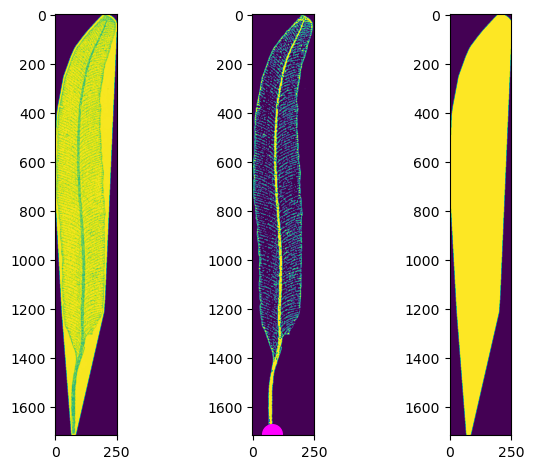

In [182]:
# Single leaf test
i = 20  # index of leaf

grayscale, thresholded, mask, bbox, index = leaf_outputs[i]
base_pt = corrected_bases[i]

plt.subplot(1,3,1)
plt.imshow(grayscale)

plt.subplot(1,3,2)
plt.imshow(thresholded)
plt.scatter(base_pt[1], base_pt[0], c="magenta", s=200)

plt.subplot(1,3,3)
plt.imshow(mask)
plt.tight_layout()

# Get skeleton
Returns True/False image array of skeleton

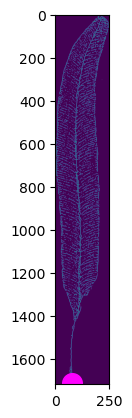

In [183]:
norm_image = thresholded/255 # normalize image
skeleton = skeletonize(norm_image) # skeletonize image
plt.imshow(skeleton)
plt.scatter(base_pt[1], base_pt[0], c="magenta", s=200)

# Get inverted threshold image array 

In [184]:
inv_img = cv2.bitwise_not(thresholded) # invert image
masked_skeleton = np.ma.masked_where(skeleton == False, skeleton)

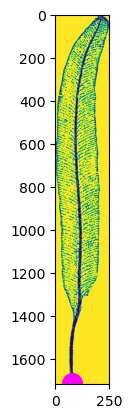

In [185]:
plt.imshow(inv_img)
plt.scatter(base_pt[1], base_pt[0], c="magenta", s=200)

In [186]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import numpy as np
from scipy.ndimage import distance_transform_edt

import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

def compute_skeleton_guided_cost(thresh_inverted, skeleton, distance_multiplier=1.0, visualize=False):
    """
    Create a cost array where foreground pixels (0s in inverted threshold)
    are weighted by distance to the nearest skeleton pixel. Background pixels (255)
    remain high-cost.

    Parameters:
    - thresh_inverted: np.ndarray, uint8, 0 = vein, 255 = background
    - skeleton: boolean array, True = skeleton pixel
    - distance_multiplier: float, scale for distance transform in foreground
    - visualize: bool, optionally shows a debug visualization

    Returns:
    - cost_array: np.ndarray, float32, same shape as input
    """

    # Define mask of foreground (veins)
    vein_mask = thresh_inverted == 0

    # Distance to nearest skeleton pixel
    dist_to_skeleton = distance_transform_edt(~skeleton)

    # Initialize cost array
    cost_array = np.full_like(thresh_inverted, fill_value=255, dtype=np.float32)

    # Assign cost in the vein region proportional to distance to skeleton
    cost_array[vein_mask] = dist_to_skeleton[vein_mask] * distance_multiplier

    if visualize:
        # Stretching for visualization purposes only
        vis_array = cost_array.copy()
        vis_array[~vein_mask] = np.nan  # Mask background for better contrast
        plt.imshow(vis_array, cmap='inferno')
        plt.title(f"Skeleton-guided cost map (mult={distance_multiplier})")
        plt.colorbar(label='Cost')
        plt.show()

    return cost_array



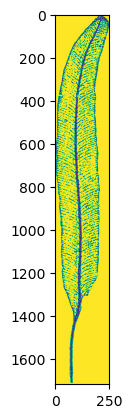

In [187]:
cost = compute_skeleton_guided_cost(inv_img, skeleton, distance_multiplier=30)

plt.imshow(cost)

(array([[   0.,    0.,    0., ...,    0.,    0., 1717.],
        [   0.,    0.,    0., ...,    0.,    0., 1717.],
        [   0.,    0.,    0., ...,    0.,    0., 1717.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0., 1717.],
        [   0.,    0.,    0., ...,    0.,    0., 1717.],
        [   0.,    0.,    0., ...,    0.,    0., 1717.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 252 BarContainer objects>)

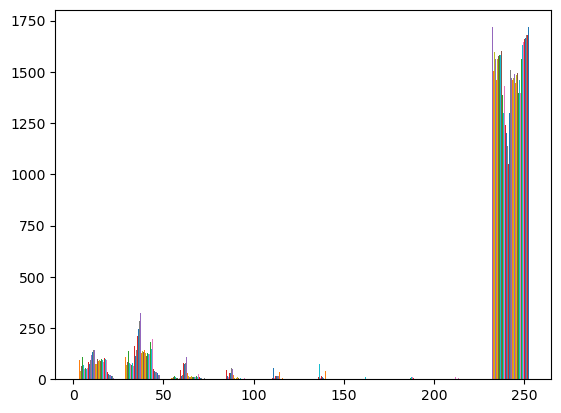

In [188]:
plt.hist(cost)

# Calculate MCP

In [189]:
import numpy as np
from skimage.graph import route_through_array

def compute_mcp_paths(cost_array, skeleton, base_point):
    """
    Compute minimum cost paths from each skeleton pixel to the base point.
    
    Parameters:
    - cost_array: 2D np.ndarray with precomputed costs (higher = less preferred)
    - skeleton: 2D np.ndarray of bools (True = skeleton pixels)
    - base_point: tuple (row, col) in image coordinates

    Returns:
    - all_paths: list of paths (each a list of (row, col) tuples)
    - costs: list of path costs (floats)
    - frequency_map: np.ndarray same shape as cost_array, counts how often each pixel is part of a path
    """
    skeleton_pts = np.column_stack(np.where(skeleton))
    all_paths = []
    costs = []
    frequency_map = np.zeros_like(cost_array, dtype=np.uint32)

    for i, start in enumerate(skeleton_pts):
        try:
            path, cost = route_through_array(
                cost_array, 
                start=tuple(start), 
                end=tuple(base_point), 
                fully_connected=True
            )
            for r, c in path:
                frequency_map[r, c] += 1
            all_paths.append(path)
            costs.append(cost)
        except Exception:
            continue  # Skip if no path found

    return all_paths, costs, frequency_map


In [190]:
all_paths, costs, freq_map = compute_mcp_paths(
    cost_array=cost,
    skeleton=skeleton,
    base_point=(base_pt[0], base_pt[1])
)

In [191]:
np.max(freq_map)

17839

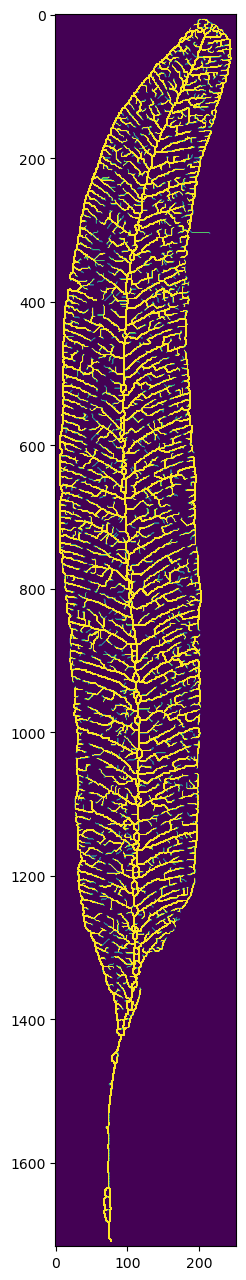

In [198]:
plt.figure(figsize=(3,16))
plt.imshow(freq_map, vmin=0, vmax=1)

# Creating graph

In [ ]:
import numpy as np
from skimage.graph import route_through_array

def compute_frequency_map(cost_array, skeleton, base_point):
    """
    Compute a frequency map by calculating minimum cost paths from each skeleton pixel to a base point.

    Parameters:
    - cost_array: 2D array of traversal costs.
    - skeleton: Boolean 2D array indicating skeleton pixels (True = part of skeleton).
    - base_point: Tuple (row, col) indicating the base point for MCP calculations.

    Returns:
    - freq_map: 2D array where each pixel's value is the number of times it was traversed in all paths.
    """
    freq_map = np.zeros_like(cost_array, dtype=np.uint32)
    skeleton_coords = np.column_stack(np.where(skeleton))

    for start in skeleton_coords:
        try:
            path, _ = route_through_array(cost_array, start=start, end=base_point, fully_connected=True)
            for r, c in path:
                freq_map[r, c] += 1
        except Exception:
            continue  # Skip if path not found

    return freq_map


In [ ]:
import numpy as np
import networkx as nx

def freq_map_to_graph(freq_map, retain_largest_component=True, weighted=False):
    """
    Converts a frequency map into a NetworkX graph with embedded spatial coordinates.

    Parameters:
    - freq_map: 2D numpy array with non-zero values indicating graph nodes.
    - retain_largest_component: Whether to keep only the largest connected component.
    - weighted: If True, edges are weighted by the average frequency of the connected pixels.

    Returns:
    - G: A NetworkX graph with nodes at (row, col) positions and optional edge weights.
    """
    nodes = np.argwhere(freq_map > 0)
    if nodes.size == 0:
        raise ValueError("No valid nodes found in the frequency map.")

    G = nx.Graph()
    for r, c in nodes:
        G.add_node((r, c), pos=(r, c), freq=int(freq_map[r, c]))

    # 8-connectivity
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               ( 0, -1),          ( 0, 1),
               ( 1, -1), ( 1, 0), ( 1, 1)]

    for r, c in nodes:
        for dr, dc in offsets:
            nr, nc = r + dr, c + dc
            if (0 <= nr < freq_map.shape[0]) and (0 <= nc < freq_map.shape[1]):
                if freq_map[nr, nc] > 0:
                    if weighted:
                        weight = (freq_map[r, c] + freq_map[nr, nc]) / 2
                        G.add_edge((r, c), (nr, nc), weight=weight)
                    else:
                        G.add_edge((r, c), (nr, nc))

    if retain_largest_component:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    return G


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.graph import route_through_array
from scipy.ndimage import distance_transform_edt
import cv2

def compute_leaf_path_frequency_map(
    grayscale,
    thresholded,
    mask,
    base_point_global,
    bbox,
    max_paths=1000,
    exponent=4.0,
    center_exponent=6.0,
    clahe_contrast=True,
    visualize=False,
    seed=42
):
    """
    Compute a frequency map of MCP paths from randomly sampled thresholded pixels to a base point.
    Returns: frequency_map (same shape as input leaf image)
    """
    np.random.seed(seed)

    min_row, min_col, max_row, max_col = bbox
    leaf_shape = grayscale.shape

    # Convert global base point to local crop coordinates
    base_row, base_col = base_point_global
    local_base = np.array([base_row - min_row, base_col - min_col])

    # Fallback: find nearest pixel inside mask if base is outside
    if not (0 <= local_base[0] < leaf_shape[0]) or not (0 <= local_base[1] < leaf_shape[1]) or mask[tuple(local_base)] == 0:
        mask_coords = np.column_stack(np.where(mask > 0))
        dists = np.linalg.norm(mask_coords - local_base, axis=1)
        local_base = mask_coords[np.argmin(dists)]

    # Optional: enhance grayscale contrast using CLAHE
    if clahe_contrast:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        grayscale = clahe.apply(grayscale.astype(np.uint8))

    # Normalize grayscale to [0, 1]
    norm_gray = grayscale.astype(np.float32) / 255.0
    norm_gray = 1.0 - norm_gray + 1e-3  # Darker veins have lower cost
    gray_cost = norm_gray ** exponent

    # Emphasize vein centers using distance transform
    dist_to_edge = distance_transform_edt(mask)
    if dist_to_edge.max() > 0:
        dist_norm = dist_to_edge / dist_to_edge.max()
        center_bonus = dist_norm ** center_exponent
    else:
        center_bonus = np.ones_like(dist_to_edge)

    # Final cost: low in center of veins, high elsewhere
    cost_array = gray_cost / center_bonus+ 1e-6
    cost_array[mask == 0] = 1e6  # Strong penalty for background

    # Find thresholded points and sample from them
    candidate_coords = np.column_stack(np.where(thresholded > 0))
    if len(candidate_coords) == 0:
        print("No thresholded pixels found.")
        return None

    if len(candidate_coords) > max_paths:
        sampled_indices = np.random.choice(len(candidate_coords), max_paths, replace=False)
        sampled_coords = candidate_coords[sampled_indices]
    else:
        sampled_coords = candidate_coords

    # Sort sampled coordinates by distance to base (closer first)
    dists_to_base = np.linalg.norm(sampled_coords - local_base, axis=1)
    sorted_coords = sampled_coords[np.argsort(dists_to_base)]

    frequency_map = np.zeros_like(grayscale, dtype=np.uint32)

    for i, coord in enumerate(sorted_coords):
        try:
            path, cost = route_through_array(cost_array, coord, local_base, fully_connected=True)
            path = np.array(path)
            frequency_map[path[:, 0], path[:, 1]] += 1
        except Exception:
            continue  # skip bad paths

    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(grayscale, cmap='gray')
        axes[0].set_title("Grayscale Input")
        axes[1].imshow(cost_array, cmap='magma')
        axes[1].set_title("Cost Landscape")
        axes[2].imshow(frequency_map, cmap='hot')
        axes[2].set_title("Path Frequency Map")
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    return frequency_map


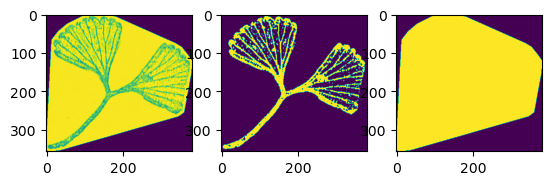

In [32]:
# Single leaf test
i = 0  # index of leaf
grayscale, thresholded, mask, bbox, index = leaf_outputs[i]
base_landmarks = np.loadtxt("base_pts.txt")  # (N, 2)
base_pt = base_landmarks[i]  # (x, y) in global coordinates

plt.subplot(1,3,1)
plt.imshow(grayscale)
plt.subplot(1,3,2)
plt.imshow(thresholded)
plt.subplot(1,3,3)
plt.imshow(mask)

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_4383/3651264450.py:58: RuntimeWarning: divide by zero encountered in divide
  cost_array = gray_cost / center_bonus+ 1e-6


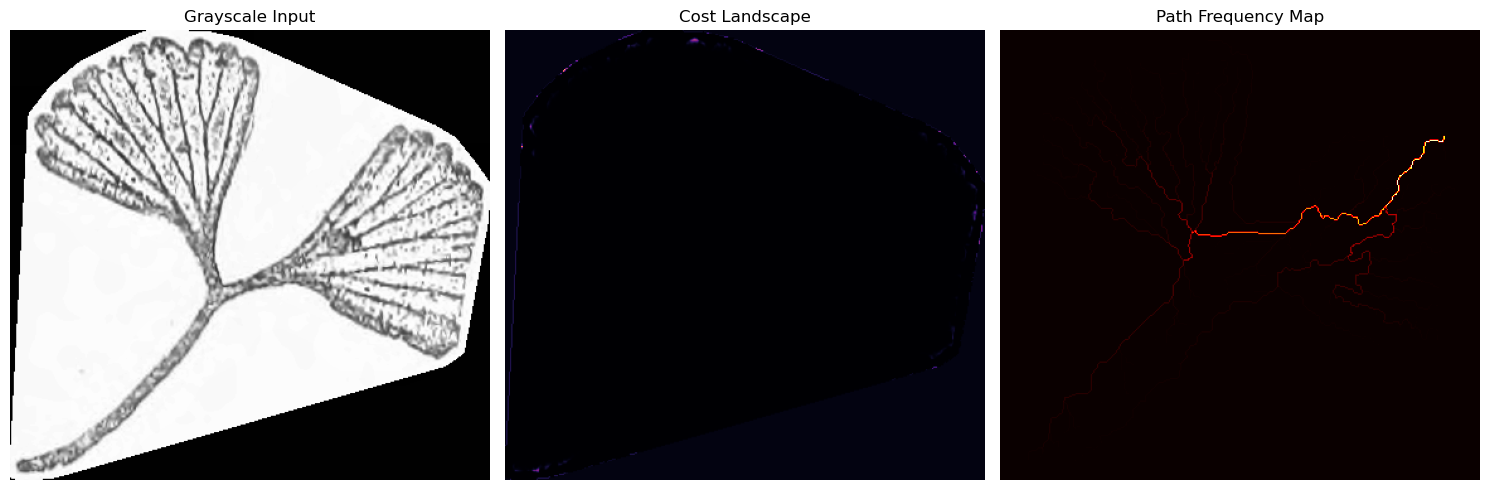

In [33]:
base_landmarks = np.loadtxt("base_pts.txt")  # (N, 2)
base_point_global = base_landmarks[i]



freq_map = compute_leaf_path_frequency_map(
        grayscale,
        thresholded,
        mask,
        base_point_global,
        bbox,
        max_paths=1000,
        exponent=4.0,
        center_exponent=6.0,
        clahe_contrast=True,
        visualize=True  # Turn off for batch mode
    )


(-0.5, 380.5, 356.5, -0.5)

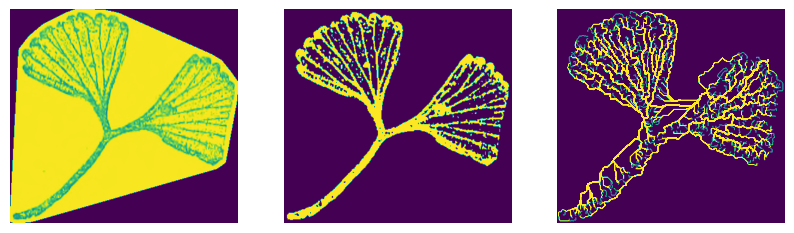

In [36]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(grayscale)
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(thresholded)
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(freq_map, vmin=0, vmax=1, )
plt.axis("off")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.graph import route_through_array
from scipy.spatial.distance import cdist
import cv2

In [ ]:
import numpy as np
from skimage.graph import route_through_array
from skimage.morphology import skeletonize
import cv2
import matplotlib.pyplot as plt

def compute_all_leaf_path_frequency_maps(
    leaf_outputs,
    base_points,
    gamma=3.0,
    decrement=0.0,
    visualize=False
):
    """
    Computes path frequency maps for all leaves in an image.
    
    Parameters:
        leaf_outputs (list): Output of extract_leaf_regions_with_bboxes.
        base_points (np.ndarray): Array of shape (N, 2), base points (x, y) for each leaf.
        gamma (float): Exponent for enhancing contrast of grayscale image.
        decrement (float): Amount to reduce cost along used paths.
        visualize (bool): Whether to visualize each frequency map.

    Returns:
        results: List of (frequency_map, bbox, idx) for each leaf.
    """
    results = []
    
    for leaf_data, base_pt in zip(leaf_outputs, base_points):
        grayscale, thresholded, mask, bbox, idx = leaf_data
        
        if grayscale is None or thresholded is None:
            results.append((None, bbox, idx))
            continue
        
        # Step 1: Prepare cost array (inverted grayscale + gamma)
        cost = 255 - grayscale
        cost = cost.astype(np.float32)
        cost = (cost / 255) ** gamma
        cost[cost == 1.0] = 0.9999  # avoid issues if all are 1

        # Step 2: Identify thresholded pixels to trace from
        trace_mask = (thresholded > 0)
        coords = np.column_stack(np.where(trace_mask))

        if coords.size == 0:
            results.append((None, bbox, idx))
            continue

        # Step 3: Order pixels by distance to base point
        base_yx = np.array([int(base_pt[1]), int(base_pt[0])])
        distances = np.linalg.norm(coords - base_yx, axis=1)
        ordered_coords = coords[np.argsort(distances)]

        # Step 4: Initialize path frequency map
        freq_map = np.zeros_like(grayscale, dtype=np.uint32)

        for i, start in enumerate(ordered_coords):
            try:
                path, _ = route_through_array(cost, start, base_yx, fully_connected=True)
                path = np.array(path)

                for y, x in path:
                    freq_map[y, x] += 1
                    if decrement > 0:
                        cost[y, x] = max(cost[y, x] - decrement, 0.001)

            except Exception:
                continue  # skip unreachable pixels

            if i % 100 == 0:
                print(f"Leaf {idx}: traced {i}/{len(ordered_coords)} paths")

        if visualize:
            plt.figure(figsize=(6, 6))
            # Apply logarithmic scaling for visibility
            log_map = np.log1p(freq_map.astype(np.float32))  # log(1 + x)
            plt.imshow(freq_map, cmap='magma')
            plt.title(f"Leaf {idx} Path Frequency Map")
            plt.axis('off')
            plt.show()

        results.append((freq_map, bbox, idx))

    return results


In [ ]:
import numpy as np

# Load base and middle points
base_landmarks = np.loadtxt("base_pts.txt")  # (N, 2)
center_landmarks = np.loadtxt("middle_pts.txt")  # (N, 2)

# Extract masked leaves and bounding boxes
leaf_outputs = extract_leaf_regions_with_bboxes("test.jp2", center_landmarks)

# Compute path frequency maps
results = compute_all_leaf_path_frequency_maps(
    leaf_outputs,
    base_landmarks,
    gamma=3.0,
    decrement=0.01,
    visualize=True
)